In [25]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import itertools as it
from collections import Counter, defaultdict, deque
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from toolz.curried import get, curry, compose

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Define environment

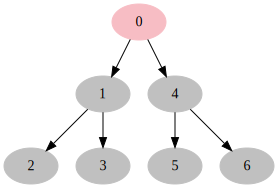

In [26]:
from distributions import Normal
from mouselab import MouselabEnv
from exact import solve

def make_env():
    reward = Normal(3, 6).to_discrete(6).apply(compose(int, round))
    return MouselabEnv.new_symmetric([2,2], reward, cost=1)

env = make_env()
env.render()

# Optimal policy

Because we can compute the true optimal Q function, we can implement the optimal policy
as a `SoftmaxPolicy` using `Q` as a preference function, and a very low temperature.

In [27]:
from policies import SoftmaxPolicy
Q, V, *_ = solve(env)
V(env.init)
optimal_policy = SoftmaxPolicy(Q)

## Simulate rollouts

Running rollouts of the optimal policy on 200 randomly selected environments.

In [28]:
from agents import run_episode

def simulate(policy, envs, seed=None, repeat=1):
    if seed is None:
        seed = np.random.randint(1e5)
    np.random.seed(seed)
    for env_id, env in envs.items():
        for _ in range(repeat):
            trace = run_episode(policy, env)
            for s, a, r in zip(*get(['states', 'actions', 'rewards'], trace)):
                yield {'seed': seed, 'cost': abs(env.cost), 'env_id': env_id,
                       'state': s, 'action': a, 'reward': r}

envs = Series([make_env() for _ in range(200)])
df_optimal = DataFrame(simulate(optimal_policy, envs))

## View rollouts

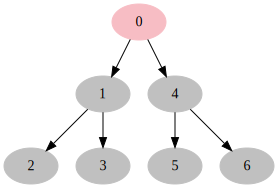

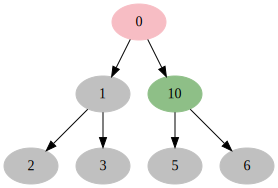

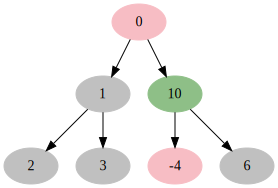

In [29]:
from IPython.display import display
def render(trace):
    for i, (s, a, r) in enumerate(zip(*get(['states', 'actions', 'rewards'], trace))):
        env._state = s
        dot = env.render()
        display(dot)

from agents import run_episode
trace = run_episode(optimal_policy, env)
render(trace)

## Model

`SoftMaxPolicy` selects actions by sampling from action probabilities generated by its
`action_distribution` method. We can use that method as a likelihood model as well.
I print summary statistics to get an idea of the fit quality. "Predictive power" (a name I made up)
is very similar to _perplexity_, but it's in probability units.

In [24]:
def policy_model(policy, data):
    return data.apply(lambda row: policy.action_distribution(row.state)[row.action], axis=1)

logp_optimal = np.log(policy_model(optimal_policy, df_optimal))
print('Probabilities of optimal policy actions under the optimal model')
print(np.exp(logp_optimal).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_optimal.mean()):.3f}', )

Probabilities of optimal policy actions under the optimal model
0.333333      5
0.333333     10
0.333334     13
0.500000      2
0.500000    459
0.500000      2
1.000000    427
dtype: int64

Predictive power: 0.682


# Random Policy

Now we can do the same thing again (without redefining functions) for the random policy.
Note that the random policy is uniform oveer *legal* actions only. As we would hope, it
less predictive of itself compared to the optimal policy.

In [ ]:
rand_policy = MouselabPolicy({'term_reward': 0})
# NOTE: must run one episode before calling for action_distribution
run_episode(rand_policy, env)
env.reset()
env.step(2)
print(env._state)
print(rand_policy.action_distribution(env._state))

In [ ]:
df = DataFrame(simulate(rand_policy, envs))
logp_rand = np.log(policy_model(rand_policy, df))
print('Probabilities of random policy actions under the random model')
print(np.exp(logp_rand).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_rand.mean()):.3f}', )

# Best first

This is just a start, not sure it's correct.

In [ ]:
def best_first_pref(state, action, satisfice=9):
    if action == env.term_action:
        if env.expected_term_reward(state) > satisfice:
            return 1e10  # always terminate
        else:
            return -1e10  # never terminate (unless it's the only option)
    q = env.node_quality(action, state)  # note backwards arguments!  plz don't ask why...
    return q.expectation()  # node_quality is a distribution, we just want the mean

best_first_policy = SoftmaxPolicy(best_first_pref)
run_episode(best_first_policy, env)
df = DataFrame(simulate(best_first_policy, envs))

In [ ]:
logp_best_first = np.log(policy_model(best_first_policy, df))
print('Probabilities of best_firstom policy actions under the best_firstom model')
print(np.exp(logp_best_first).value_counts().sort_index())
print(f'\nPredictive power: {np.exp(logp_best_first.mean()):.3f}', )